In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
block_size = 3

X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)


In [8]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [9]:
C = torch.randn((27,2))


In [11]:
C[5]

tensor([-1.7542, -0.5194])

In [14]:
emb = C[X]
emb.shape
# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)
list = [emb[:, :, 0], emb[:, :, 0]]#, emb[:, 2, :]]
list

[tensor([[ 0.4321,  0.4321,  0.4321],
         [ 0.4321,  0.4321, -2.0170],
         [ 0.4321, -2.0170,  1.6884],
         ...,
         [-0.8986, -0.8986, -0.6345],
         [-0.8986, -0.6345, -0.8986],
         [-0.6345, -0.8986, -0.8818]]),
 tensor([[ 0.4321,  0.4321,  0.4321],
         [ 0.4321,  0.4321, -2.0170],
         [ 0.4321, -2.0170,  1.6884],
         ...,
         [-0.8986, -0.8986, -0.6345],
         [-0.8986, -0.6345, -0.8986],
         [-0.6345, -0.8986, -0.8818]])]

In [15]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [16]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([228146, 100])

In [17]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [18]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [19]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)

In [20]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [21]:
# dataset
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [22]:
# initialization

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [23]:
sum(p.nelement() for p in parameters)

11897

In [24]:
for p in parameters:
    p.requires_grad = True

In [25]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [26]:
lri = []
lossi = []
stepi = []

In [33]:
ix = torch.randint(0, Xtr.shape[0], (32, ))


In [34]:
for i in range (50000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    #lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    # lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)

print("Loss: ", loss.item())


Loss:  2.058915376663208


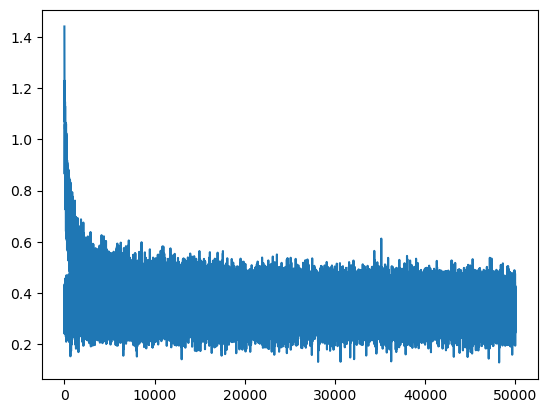

In [200]:
plt.plot(stepi, lossi)

In [201]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Ytr)
print("Loss: ", loss.item())

Loss:  2.1632561683654785


In [202]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Ydev)
print("Loss: ", loss.item())

Loss:  2.1936123371124268


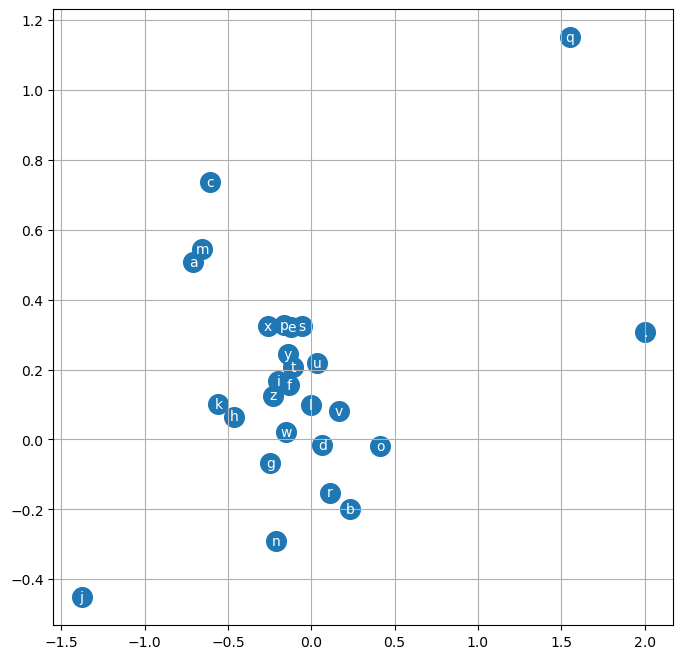

In [203]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [206]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size

    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mona.
mayah.
see.
mad.
ryah.
rethan.
endra.
gradeerdieliah.
mikola.
eden.
eson.
areelynn.
honea.
nosadbergiairiel.
kin.
renelionnie.
casu.
zayven.
kylene.
els.
